<a href="https://colab.research.google.com/github/AndersonGabrielCalasans/Guia-modelagem-preditiva-tensorflow/blob/main/Guia_modelagem_preditiva_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Guia de Modelagem Preditiva com Linguagem Python e TensorFlow**

Esse projeto foi disponibilizado pela [**Data Science Academy**](https://www.datascienceacademy.com.br/), no curso de **Python Fundamentos Para Análise de Dados 3.0**, com o objetivo de mostrar um guia de modelagem preditiva utilizando Python e TensorFlow, o principal framework para construção de modelos de Machine Learning e Deep Learning e para construir aplicações comerciais de Inteligência Artificial.

Nele nós vamos criar um modelo preditivo para prever a mediana dos preços de habitações em Boston, Massachusetts, com base em 506 habitações observadas no dataset **The Boston Housing Dataset**, utilizando um modelo de regressão linear simples.



## **Instalando e carregando os pacotes utilizados**

In [4]:
# Versão da linguagem python
from platform import python_version
print('Versão da linguagem Python utilizada neste projeto:', python_version())

Versão da linguagem Python utilizada neste projeto: 3.7.14


In [5]:
# Instala o TensorFlow
!pip install -q tensorflow

In [6]:
# Instala o pydot - que permite criar a árvore representando o grafo computacional do modelo do projeto
!pip install -q pydot

In [50]:
# Imports do PyData
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Import TensorFlow
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
print(tf.__version__)

2.8.2


## **Carregando os Dados**

Os dados utilizados neste projeto foram disponibilizados no Dataset **The Boston Housing Dataset**, que são dados públicos coletados pela U.S Census Servic de preço de habitações da região de Boston, na cidade de Massachusetts.

O link contendo todas as informações do Dataset é [este aqui](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html).


In [10]:
# Download dos Dados
import ssl
ssl.create_default_htts_context = ssl._create_unverified_context
dataset_path = keras.utils.get_file("housing.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data")

57344/49082 [===================================] - 0s 1us/step


In [11]:
df = pd.read_csv(dataset_path)
df.head()

,0.00632 18.00 2.310 0 0.5380 6.5750 65.20 4.0900 1 296.0 15.30 396.90 4.98 24.00
0,0.02731 0.00 7.070 0 0.4690 6.4210 78...
1,0.02729 0.00 7.070 0 0.4690 7.1850 61...
2,0.03237 0.00 2.180 0 0.4580 6.9980 45...
3,0.06905 0.00 2.180 0 0.4580 7.1470 54...
4,0.02985 0.00 2.180 0 0.4580 6.4300 58...


O Dataset importado tem um problema, ele não possui nome nas colunas para corrigir esse problema, irei criar uma lista com o nome das colunas, de acordo com a nomenclatura da documentação original, segue a descrição de cada uma delas:

 - **CRIM** - taxa de criminalidade per capta da cidade
 - **ZN** - proporção de terrenos residenciais zoneados para lotes acima de 25.000 sq.ft(pé quadrado, medida proporcional a 0,093m²).
 - **INDUS** - proporção de acres de negócios não varejistas (grandes empresas) por cidade.
 - **CHAS** - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
 - **NOX** - concentração de óxidos nítricos (partes por 10 milhões)
 - **RM** - número médio de cômodos por domicílio
 - **AGE** -proporção de unidades ocupadas pelos proprietários construídas antes de 1940
 - **DIS** - distâncias ponderadas para cinco centros comerciais de Boston
 - **RAD** - índice de acessibilidade às rodovias radiais
 - **TAX** - taxa de imposto de propriedade de valor total por 10.000(dólares)
 - **PTRATIO** - relação aluno-professor por cidade
 - **B** - 1000(Bk - 0,63)^2 onde Bk é a proporção de negros por cidade 
 - **LSTAT** - % de menores de idade da população
 - **MEDV** - Valor médio das casas ocupadas pelos proprietários em $ 1.000 dólares.



In [16]:
lista_colunas = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
dataset = pd.read_csv(dataset_path, 
                      names = lista_colunas,
                      na_values = "?", 
                      comment = '\t',
                      sep = " ", 
                      skipinitialspace = True)
dataset.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [17]:
# Shape
dataset.shape

(506, 14)

Para criar o modelo, vamos dividir os dados em 80/20, 80% para treinar o modelo e 20% para dados de teste, onde vamos verificar se está seguindo o padrão desejado.

In [18]:
# Split dos dados
dados_treino = dataset.sample(frac=0.8, random_state=0) #permite criar uma amostra com 80% dos dados do Dataset
dados_teste = dataset.drop(dados_treino.index) #cria uma amostra com os dados restantes

## **Criando a Modelagem Preditiva de Regressão Linear Simples**

No **modelo de regressão linear simples** é um modelo de aprendizado supervisionado, no qual, desejamos modelar a **relação** entre uma **variável dependente(y)** e uma **variável independente(x)**.

Para esse estudo, iremos adotar como variáveis de **entrada** e **saída**, repectivamente, as variáveis **RM**, que representa o número médio de cômodos por domicílio e a variável **MEDV**, que é o valor da mediana das casas ocupadas pelos proprietários em $ 1.000 dólares.

Com isso iremos atender ao objetivo de prever o valor da mediana das casas ocupadas por proprietários com base no número de quartos.

Vamos criar um plot mostrando a relação atual entre as variáveis.

Basicamente temos $MEDV=f(RM)$ e queremos estimar a função $f()$ usando regressão linear.

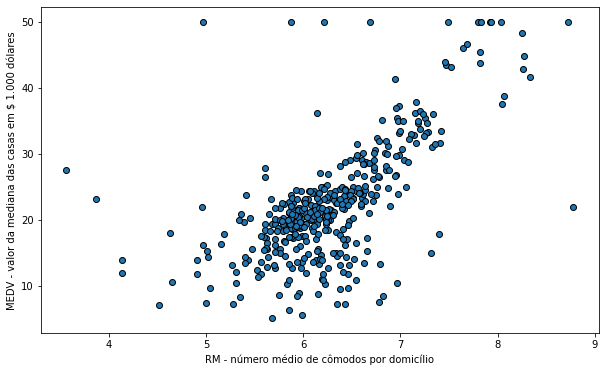

In [25]:
# Representação visual dos dados de treino
fig, ax = plt.subplots(figsize=(10,6))
x = dados_treino['RM']
y = dados_treino['MEDV']
ax.scatter(x, y, edgecolors= (0,0,0))
ax.set_xlabel('RM - número médio de cômodos por domicílio')
ax.set_ylabel('MEDV - valor da mediana das casas em $ 1.000 dólares')
plt.show()

Com base no gráfico, já podemos ver que há uma relação entre as duas variáveis estudadas, com isso, faz sentido aplicarmos o modelo de regressão linear simples para tentar prever quais os possíveis valores da mediana das casas com base na quantidade de quartos.



In [26]:
# Separando os valores de x e y para treinar o modelo
x_treino = dados_treino['RM']
y_treino = dados_treino['MEDV']
x_teste = dados_teste['RM']
y_teste = dados_teste['MEDV']

## **Criação do Modelo**

Queremos encontrar os parâmetros (**w**) que permitem prever a saída y a partir da entrada x:

$y = w_1 x + w_0$

A fórmula acima pode ser definida com a seguinte camada densa em um modelo de rede neural artificial:

*layers.Dense(1, use_bias=True, input_shape=(1,))*

In [30]:
# Função para construir o modelo
def modelo_linear():

  # Cria modelo
  model = keras.Sequential([layers.Dense(1, use_bias = True, input_shape = (1,), name = 'layer')])

  # Otimizador
  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01, 
                                         beta_1 = 0.9, 
                                         beta_2 = 0.99, 
                                         epsilon = 1e-05, 
                                         amsgrad = False, 
                                         name = 'Adam')
  
  # Compila o modelo
  model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mae','mse'])
  # mae = Mean Absolute Error e mse = Mean Squared Error
  return model

In [31]:
# Cria modelo
modelo = modelo_linear()

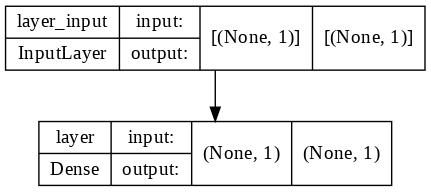

In [35]:
# Plot do modelo
tf.keras.utils.plot_model(modelo, 
                          to_file = '/content/drive/MyDrive/Guia-modelagem-preditiva-tensorflow/modelo.png', 
                          show_shapes = True, 
                          show_layer_names = True,
                          rankdir = 'TB', 
                          expand_nested = False, 
                          dpi = 100)

## Treinamento do Modelo

In [36]:
# Hiperparâmetros
n_epochs = 4000
batch_size = 256
n_idle_epochs = 100
n_epochs_log = 200
n_samples_save = n_epochs_log * x_treino.shape[0]
print('Checkpoint salvo a cada {} amostras'.format(n_samples_save))

Checkpoint salvo a cada 81000 amostras


In [37]:
# Callback
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                 patience = n_idle_epochs, 
                                                 min_delta = 0.001)

In [38]:
# Lista para as previsões
predictions_list = []

In [39]:
# Caminho ppara salvar o checkpoint
checkpoint_path = "/content/drive/MyDrive/Guia-modelagem-preditiva-tensorflow/dados/"

In [40]:
# Create a callback that saves the model's weights every n_samples_save
checkpointCallback = tf.keras.callbacks.ModelCheckpoint(filepath = "/content/drive/MyDrive/Guia-modelagem-preditiva-tensorflow/dados/", 
                                                        verbose = 1, 
                                                        save_weights_only = True,
                                                        save_freq = n_samples_save)

In [41]:
# Salva a primeira versão do modelo
modelo.save_weights(checkpoint_path.format(epoch = 0))

In [42]:
# Treinamento
history = modelo.fit(x_treino, 
                     y_treino, 
                     batch_size = batch_size,
                     epochs = n_epochs, 
                     validation_split = 0.1, 
                     verbose = 1, 
                     callbacks = [earlyStopping, checkpointCallback])

A saída de streaming foi truncada nas últimas 5000 linhas.
2/2 [==============================] - 0s 29ms/step - loss: 255.9379 - mae: 13.7616 - mse: 255.9379 - val_loss: 324.7111 - val_mae: 15.0404 - val_mse: 324.7111
Epoch 124/4000
2/2 [==============================] - 0s 37ms/step - loss: 252.8367 - mae: 13.6557 - mse: 252.8367 - val_loss: 321.3213 - val_mae: 14.9349 - val_mse: 321.3213
Epoch 125/4000
2/2 [==============================] - 0s 31ms/step - loss: 249.6827 - mae: 13.5508 - mse: 249.6827 - val_loss: 317.9716 - val_mae: 14.8300 - val_mse: 317.9716
Epoch 126/4000
2/2 [==============================] - 0s 29ms/step - loss: 246.6533 - mae: 13.4469 - mse: 246.6533 - val_loss: 314.6447 - val_mae: 14.7250 - val_mse: 314.6447
Epoch 127/4000
2/2 [==============================] - 0s 28ms/step - loss: 243.6150 - mae: 13.3443 - mse: 243.6150 - val_loss: 311.3522 - val_mae: 14.6251 - val_mse: 311.3522
Epoch 128/4000
2/2 [==============================] - 0s 27ms/step - loss: 240.63

In [43]:
# Métricas do histórico de treinamento
print('keys:', history.history.keys())

keys: dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


In [44]:
# Retornando os valores desejados para o plot
mse = np.asarray(history.history['mse'])
val_mse = np.asarray(history.history['val_mse'])

In [45]:
# Prepara os valores para o dataframe
num_values = (len(mse))
values = np.zeros((num_values, 2), dtype = float)
values[:,0] = mse
values[:,1] = val_mse

In [46]:
# Cria o dataframe
steps = pd.RangeIndex(start = 0, stop = num_values)
df = pd.DataFrame(values, steps, columns = ["MSE em Treino", "MSE em Validação"])

In [48]:
df.head()

,MSE em Treino,MSE em Validação
0,952.060974,1058.723511
1,943.238586,1049.630981
2,934.746033,1040.588623
3,925.990662,1031.606567
4,917.444702,1022.663086


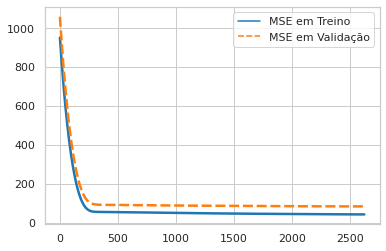

In [51]:
# Plot
sns.set(style = "whitegrid")
sns.lineplot(data = df, palette = "tab10", linewidth  = 2.5)

In [52]:
# Previsões com o modelo treinado
previsoes = modelo.predict(x_teste).flatten()

In [53]:
# Imprime as previsões
previsoes

array([20.66584 , 18.098274, 23.778614, 21.096935, 20.323494, 20.42493 ,
       24.412579, 21.711884, 20.83067 , 20.6278  , 25.813644, 23.284119,
       21.052559, 22.555058, 23.10661 , 21.407578, 27.02452 , 23.208046,
       29.617443, 19.69587 , 20.184025, 20.773613, 18.935108, 20.66584 ,
       18.694202, 23.372875, 22.70721 , 13.83168 , 16.862038, 35.69718 ,
       21.280785, 17.927101, 19.746586, 22.637474, 31.829987, 24.209713,
       21.610447, 28.108604, 25.712212, 32.52735 , 27.65849 , 30.84734 ,
       32.38788 , 16.862038, 22.910076, 23.13197 , 18.060234, 23.417255,
       37.782936, 35.842995, 17.851025, 35.20269 , 31.360851, 25.877045,
       23.512348, 22.637474, 26.09893 , 27.918411, 24.634468, 24.23507 ,
       23.024193, 18.789299, 23.271439, 22.643814, 20.87505 , 19.974815,
       21.014519, 21.984486, 21.445614, 21.350521, 27.081577, 24.754921,
       10.294146, 13.540054, 16.773281, 23.208046, 17.172684, 17.667175,
       23.246078, 21.293465, 19.981152, 25.921421, 

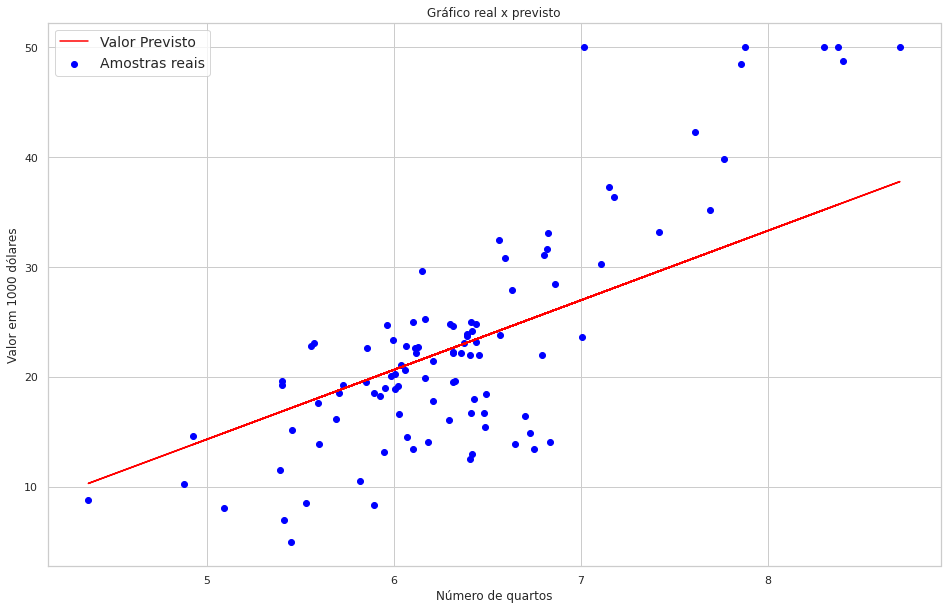

In [66]:
# Mostrando graficamente
plt.figure(figsize=(16, 10))
plt.scatter(x_teste, y_teste, color = 'blue')
plt.plot(x_teste, previsoes, color = 'red')
plt.title('Gráfico real x previsto')
plt.xlabel('Número de quartos')
plt.ylabel('Valor em 1000 dólares')
plt.legend(['Valor Previsto','Amostras reais'], fontsize=14)
plt.show()

Como o objetivo do projeto era apenas demonstrar como é feita de modo geral e introdutório, não entramos em detalhes em relação ao tratamento dos dados para que o modelo seja otimizado, contudo o objetivo foi atingido e cccom esse projeto pude ter um panorama geral de como é realizado uma ativiidade de machine learning e me dou por satisfeito com o resultado obtido.